# Semi Regular Polygon (12.12.3)

We define some scripts to create the cutting patterns for one of the 8 semi-regular tesselations.<br>
In particular for the  `triangle` + `dodecagon` tesselation defined by vertex `(12.12.3)`.

### Strategy

- We define a basic shape made of 1 dodecagon and 1 triangles using python library [Shapely](https://shapely.readthedocs.io/en/stable/manual.html).<br>
- We fill a portion of the plane with copies of this shape.
- We remove the polygons outside the frame which defines the shape of the riser
- We use the **Shapely** set operation "difference" to trip shapes too close to the edge (leaving some margin for welding the risers)


### Process Overview

<img src="./img/process_overview.png" >

In [975]:
# Imports
import math
from math import pi, sin, cos

from shapely.geometry import Polygon
from shapely import affinity, polygons

import matplotlib.pyplot as plt

In [976]:
import sys
sys.path.append('../..')  # Add the parent directory to Python path
from polygon_utils import (
    create_regular_polygon,
    plot_polygon_dict,
    plot_polygon_list,
    blue_plot,
    center_rectangle_on_polygons,
    is_polygon_inside_frame,
    save_polygon_list_to_svg,
    crop_and_save_tile,
)

### Canvas and Polygon sizes

In [977]:
# DRAWING PARAMS:
drawing_height = 300
drawing_width = 1200
tabica_height = 170
tabica_width = 905

dodeca_radius = 28
hexa_radius = dodeca_radius * sin(pi/12)/sin(pi/6)
square_radius = dodeca_radius * sin(pi/12)/sin(pi/4)

frame_shift = 11.5  # move box that selects region of interest down by Xmm
INSET_DISTANCE = 3.1   # X ratio gives gaps of about 2Xmm solid channels

bottom_margin = 26 # solid margin, at bottom of step
top_margin = tabica_height - 120 - bottom_margin # solid margin, at top of step

side_margin = 20 # solid margin left and right

### Polygon creation

In [978]:
# Create a square (4 sides)
square = create_regular_polygon(0,0,square_radius, 4)

# Create a hexagon (6 sides)
hexagon = create_regular_polygon(0,0,hexa_radius, 6)

# Create a dodecagon (12 sides)
dodeca = create_regular_polygon(0,0,dodeca_radius, 12)

### Dictionary of Polygons

Here we save a dictionary of polygons.

The reason for using a dictionary is to be able to plot polygon with its key representing its label.
This allows us to easily visualize the transforms that define the position of the polygon.

In [979]:
dodeca = affinity.rotate(dodeca, 45, origin=(0,0))
square_l = affinity.rotate(square, -45 - 360/12, origin=(0,0))
square_r = affinity.rotate(square, -45 + 360/12, origin=(0,0))
square_flat = affinity.rotate(square, 45, origin=(0,0))
hexa = affinity.rotate(hexagon, 0, origin=(0,0))

square_r = affinity.translate(square_r, 
        (dodeca_radius*cos(pi/12) + square_radius*cos(pi/4))*sin(pi/6), 
        -(dodeca_radius*cos(pi/12) + square_radius*cos(pi/4))*cos(pi/6))
,

square_l = affinity.translate(square_l, 
        -(dodeca_radius*cos(pi/12) + square_radius*cos(pi/4))*sin(pi/6), 
        -(dodeca_radius*cos(pi/12) + square_radius*cos(pi/4))*cos(pi/6))

square_rr = affinity.translate(square_flat, 
        (dodeca_radius*cos(pi/12) + square_radius*cos(pi/4)),0)

hexa_down = affinity.translate(hexa, 0,
        -(dodeca_radius*cos(pi/12) + hexa_radius*cos(pi/6)))

hexa_r = affinity.translate(hexa,
        (dodeca_radius*cos(pi/12) + hexa_radius*cos(pi/6))*sin(pi/3), 
        -(dodeca_radius*cos(pi/12) + hexa_radius*cos(pi/6))*cos(pi/3))

polygon_dict = {}
polygon_dict['D0'] = dodeca
polygon_dict['S1'] = square_r
polygon_dict['S2'] = square_l
polygon_dict['S3'] = square_rr
polygon_dict['H0'] = hexa_down
polygon_dict['H1'] = hexa_r

### Plotting Dictionaries of Shapes

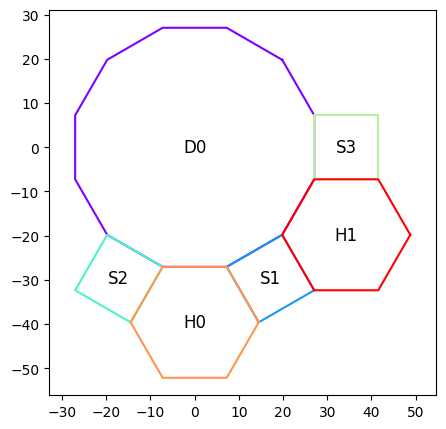

In [980]:
plot_polygon_dict(polygon_dict)

### Translations
The collection of polygons above can be translated to fill the plane as shown below:

In [981]:
# Define the translation
x_offset = 2*(dodeca_radius*cos(pi/12) + square_radius*cos(pi/4))
y_offset = 0
# Translate all polygons
translated_polygons_1 = {
    f"{key}-t": affinity.translate(poly, x_offset, y_offset) for key, poly in polygon_dict.items()
}

x_offset = dodeca_radius*cos(pi/12) + square_radius*cos(pi/4)
y_offset = square_radius*cos(pi/4) + 2*hexa_radius*cos(pi/6) + dodeca_radius*cos(pi/12)

translated_polygons_2 = {
    f"{key}-r": affinity.translate(poly, x_offset, y_offset) for key, poly in polygon_dict.items()
}

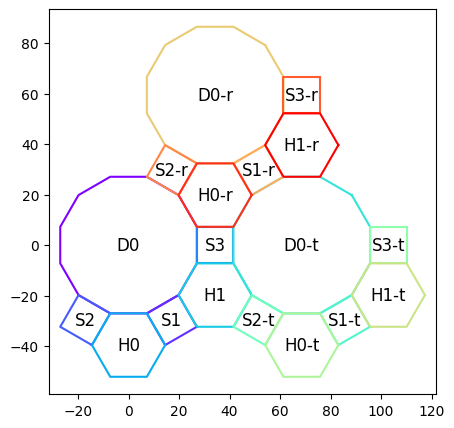

In [982]:
super_polys = { **polygon_dict, **translated_polygons_1 , **translated_polygons_2}
plot_polygon_dict(super_polys)

## List of Polygons

In order to generate the full list of polygons that fill the plane, we will store them in a list
instead of a dictionary.  <br>The basic idea is to use the basic initial shape
and apply a series of translations to generate the full list of polygons.

In [983]:
initial_polygon_list = list(polygon_dict.values())

### Plane Translations

We define two translations
- Up and to the right (as shown in plot above)
- Down and to the right 

In [984]:
# Translate all polygons
def translate_polygon_right(polygon_list, nr_translations): 
    """
    takes a list of polygons and applies the "to-the-right"
    unit translation.  It returns a new list of polygons 
    with the translation applied
    """
    
    # Define the basic -> RIGHT translation
    x_offset = 2*(dodeca_radius*cos(pi/12) + square_radius*cos(pi/4))*nr_translations
    y_offset = 0
    
    right_polygons = [
    affinity.translate(poly, x_offset, y_offset) for poly in polygon_list
    ]
    return right_polygons

def translate_polygon_up(polygon_list, nr_translations):
    """
    takes a list of polygons and applies the up
    unit translation.  It returns a new list of polygons 
    with the translation applied
    """
    # Define the basic UP
    x_offset = dodeca_radius*cos(pi/12) + square_radius*cos(pi/4)
    y_offset = square_radius*cos(pi/4) + 2*hexa_radius*cos(pi/6) + dodeca_radius*cos(pi/12)*nr_translations

    up_polygons = [
    affinity.translate(poly, x_offset, y_offset) for poly in polygon_list
    ]
    return up_polygons


### Plotting Lists of Polygons

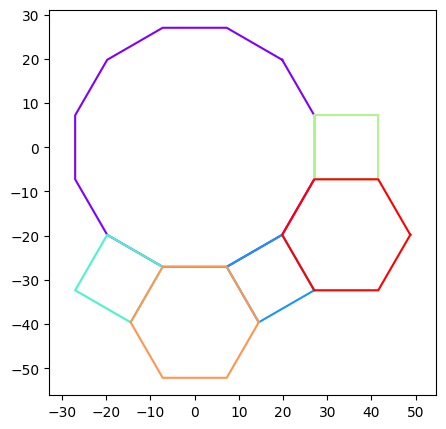

In [985]:
initial_polygon_list = list(polygon_dict.values())
plot_polygon_list(initial_polygon_list)

### Translation Strategy

1. We create a horizontal row made of copies of the "basic polygon group"
   * This row is created by translating the last copied group to the right 
   * We repeat this process until we have a big enough column (about 40 copies)

2. We then select the whole row created and make two copies translated up and right.


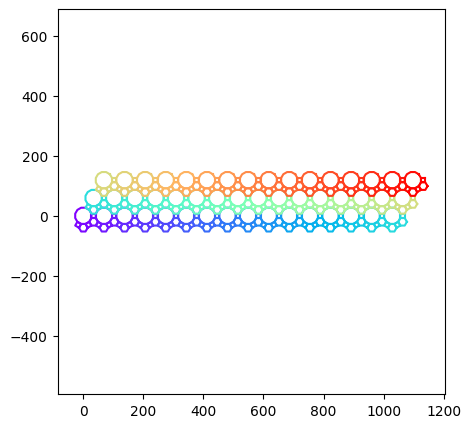

In [986]:
first_row = []
for nr_copies in range(16):
    n_copy = translate_polygon_right(initial_polygon_list, nr_copies)
    first_row += n_copy

full_polygon_list = first_row
mid_row = translate_polygon_up(first_row, 1)
top_row = translate_polygon_up(mid_row, 1)
full_polygon_list += mid_row + top_row


plot_polygon_list(full_polygon_list)
# save_polygons_to_svg(full_poly, filename='tramo_2.1.svg')

# FRAME

The frame defines the rectangle that will become the cut sheet metal.
We want to delete polygons outside of this frame, and potentially "trim" some of the polygons at the edges,
to ensure the sheet metal can we welded robustly to the next piece.

In [987]:
frame = polygons([[0,0],
                  [0 + tabica_width, 0],
                  [0 + tabica_width, 0 + tabica_height],
                  [0, 0 + tabica_height]])

### Function to center frame around the polygons

In [988]:
# Center the rectangle
centered_frame = center_rectangle_on_polygons(full_polygon_list, frame)

In [989]:
centered_frame = affinity.translate(centered_frame, 0, frame_shift)

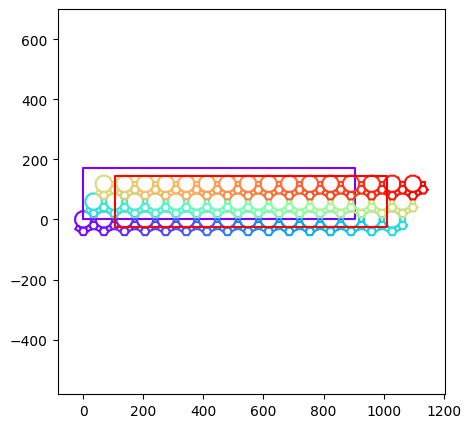

In [990]:
plot_polygon_list([frame] + full_polygon_list + [centered_frame])

### Delete polygons *mostly* outside of frame

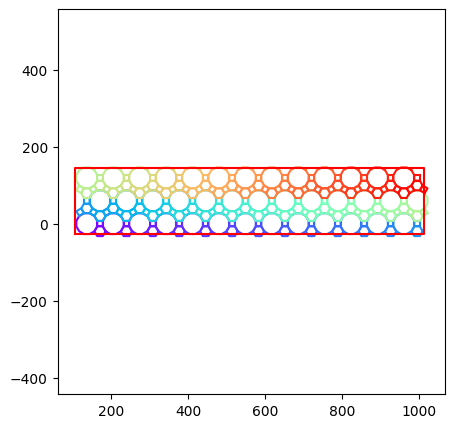

In [991]:
# Filter the full_polygon_list to keep only polygons "mostly" inside the rectangle
# by "mostly" we mean that the centroid of the polygon lies outside the frame.
filtered_polygon_list = [polygon for polygon in full_polygon_list if is_polygon_inside_frame(polygon, centered_frame)]

# Update the full_polygon_list
full_polygon_list = filtered_polygon_list

# Plot the polygons
plot_polygon_list(full_polygon_list + [centered_frame])

## Perform Inset Operation on polygons
This shrinks each polygon to leave some material between them by a specified amount

In [992]:
inset_polygon_list = []
for poly in full_polygon_list:
    inset_polygon_list.append(poly.buffer(-INSET_DISTANCE))    

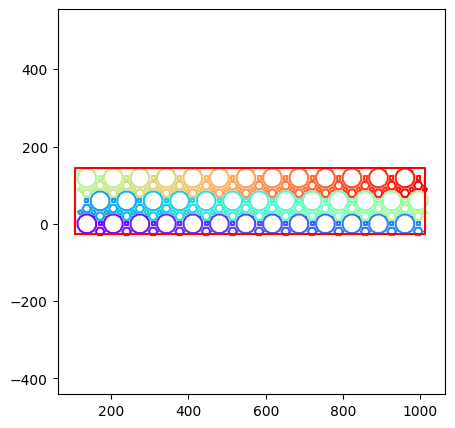

In [993]:
plot_polygon_list(inset_polygon_list + [centered_frame])

## Create Inner Tile to cut polygons
Inner tile is:

- 22 cm inside the frame (left and right)
- 26 cm higher than the bottom border of the frame
- centered horizontally
- 120 cm tall

In [994]:
# Create inner tile
# Inner tile is:
# - 22 cm inside the frame (left and right)
# - 26 cm higher than the bottom border of the frame
# - centered horizontally

# Get frame bounds for calculations
xmin, ymin, xmax, ymax = centered_frame.bounds

# Inner tile margins (in centimeters)
left_inset = 22
right_inset = 22
bottom_inset = 26

# Calculate new xmin and xmax (sides inset by 22 cm)
inner_xmin = xmin + left_inset
inner_xmax = xmax - right_inset

# Calculate new ymin (bottom inset by 26 cm)
inner_ymin = ymin + bottom_inset

# The top of the inner tile is flush with the top of the frame
inner_ymax = inner_ymin + 120

# Create the inner tile polygon
from shapely.geometry import Polygon

inner_tile = Polygon([
    (inner_xmin, inner_ymin),
    (inner_xmin, inner_ymax),
    (inner_xmax, inner_ymax),
    (inner_xmax, inner_ymin)
])

### Use inner tile to crop polygons

197


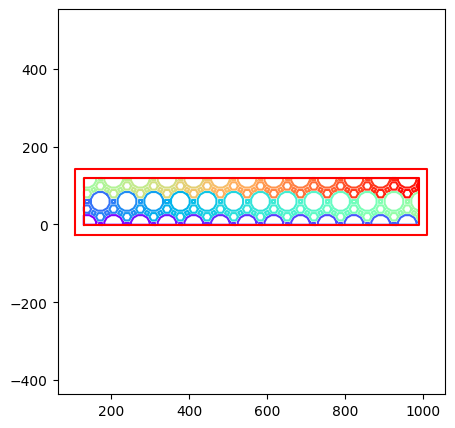

In [995]:
poly_crop = crop_and_save_tile(inset_polygon_list, inner_tile, save_holes=False)
plot_polygon_list(poly_crop + [centered_frame, inner_tile])

In [996]:
final_polygons =  poly_crop + [centered_frame]


# SANITY CHECKS

- delete any polygon with an area less than a threshold

In [997]:
len(final_polygons)

179

In [998]:

for poly in final_polygons:
    # pop polygon out of the list if area < 9
    if poly.area < 12:
        final_polygons.remove(poly)
    

In [999]:
len(final_polygons)

179

### Save POLYGONS to SVG

### SAVE POLYGONS to SVG with **RESCALING**

# SAVE


In [1000]:
save_polygon_list_to_svg(final_polygons, filename='tabica_2.7.svg')


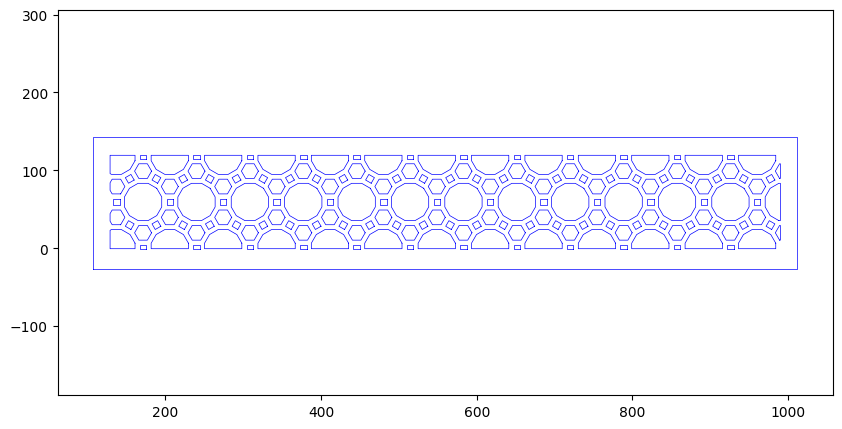

In [1001]:
blue_plot(final_polygons)

In [1002]:
# Save as PNG
plt.figure(figsize=(12, 8))
for polygon in (final_polygons):
    x, y = polygon.exterior.xy
    plt.plot(x, y, color='blue', linewidth=0.5)
plt.axis('equal')
plt.savefig('tabica_2.7.png', dpi=300, bbox_inches='tight')
plt.close()